In [1]:
import metaworld
# import environments.metaworld_envs
import gym
from environments.parallel_envs import make_vec_envs, make_env, make_metaworld_env


In [7]:
ml1 = metaworld.ML1('pick-place-v2')
# env = ml1.train_classes
ml1

In [11]:
ml1.train_classes['pick-place-v2']()

In [35]:
import gym
import metaworld
import random

class ML1Env(gym.Env):

    def __init__(self):
        ## hardcode this - easy to learn env base on https://jmlr.org/papers/volume22/21-0657/21-0657.pdf
        self.env_name = 'push-v2'
        # initialise blank env
        self.benchmark = metaworld.ML1(self.env_name)
        self.task_names = list(self.benchmark.train_classes.keys())
        self.num_tasks = len(self.task_names)

        self.env_cls = self.benchmark.train_classes[self.env_name]
        self.env = self.env_cls()

        # set a dummy task from the benchmark for init purposes
        self.set_task()
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space

        # metaworld max steps - hardcoded
        self._max_episode_steps = 500

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        info['task'] = self.task
        return obs, reward, done, info
    
    def reset(self):
        obs, _ = self.env.reset()
        return obs
    
    def get_task(self):
        return self.env_name, self.env_cls
    
    ## reset_task is automatically created in make_env using set_task
    def set_task(self, task = None):
        if task is None:
            task = random.choice(
                [task for task in self.benchmark.train_tasks if task.env_name==self.env_name]
                )

        self.task = task
        self.env.set_task(self.task)

    # duplicated for varibad temporarily
    def reset_task(self, task = None):
        if task is None:
            task = random.choice(
                [task for task in self.benchmark.train_tasks if task.env_name==self.env_name]
                )

        self.task = task
        self.env.set_task(self.task)

In [36]:
ml1_env = ML1Env()
ml1_env

In [37]:
ml1_env.reset()

array([ 0.00615235,  0.6001898 ,  0.19430117,  1.        , -0.02494481,
        0.60356566,  0.01987216,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00615235,  0.6001898 ,
        0.19430117,  1.        , -0.02494481,  0.60356566,  0.01987216,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [24]:
ml1.train_tasks

[Task(env_name='pick-place-v2', data=b'\x80\x04\x95=\x01\x00\x00\x00\x00\x00\x00}\x94(\x8c\x08rand_vec\x94\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x06\x85\x94h\x05\x8c\x05dtype\x94\x93\x94\x8c\x02f8\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89C0,\xc1O\xec%\x8c\xa4?\xd2\xa9\xac\xd8\xc2W\xe6?\x00\x00\x00@\xe1z\x94?P\xc2\x08/\x95\x86\xb8?\x89M\x80#\xc0|\xeb?\xbfE\x97\xc4\x01-\xb4?\x94t\x94b\x8c\x07env_cls\x94\x8c8metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_pick_place_v2\x94\x8c\x14SawyerPickPlaceEnvV2\x94\x93\x94\x8c\x14partially_observable\x94\x88u.'),
 Task(env_name='pick-place-v2', data=b"\x80\x04\x95=\x01\x00\x00\x00\x00\x00\x00}\x94(\x8c\x08rand_vec\x94\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x06\x85\x94h\x05\x8c\x

In [19]:
ml1_env.set_benchmark_task(1)

In [21]:
ml1_env.set_task()

In [22]:
ml1_env.reset()

array([ 0.00615235,  0.6001898 ,  0.19430117,  1.        , -0.06411003,
        0.64345405,  0.02      ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00615235,  0.6001898 ,
        0.19430117,  1.        , -0.06411003,  0.64345405,  0.02      ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [41]:
seed = 73
rank_offset = 1
episodes_per_task=2
add_done_info=True
kwargs = {}
num_processes = 30
env_name = 'ML10-v2'
envs = [make_metaworld_env(env_id=env_name, 
                    task_id = i,
                    seed=seed, rank=rank_offset + i,
                     episodes_per_task=episodes_per_task,
                     add_done_info=add_done_info,
                     **kwargs)
            for i in range(num_processes)]

In [46]:
26 %10

6

In [42]:
for i in range(num_processes):
    env = envs[i]()
    env.reset()
    print(i, env.__getattr__('env_name'), env.__getattr__('task'), '\n')

0 reach-v2 Task(env_name='reach-v2', data=b'\x80\x04\x954\x01\x00\x00\x00\x00\x00\x00}\x94(\x8c\x08rand_vec\x94\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x06\x85\x94h\x05\x8c\x05dtype\x94\x93\x94\x8c\x02f8\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89C0h\xbf\x02\x8d/\x13\xae?\x04n\xe8\x95\x1e\x9f\xe4?\x00\x00\x00@\xe1z\x94?$\xfa\xb6o\xb5\x9d\xb4?\x87f\r_\xc9\xa9\xec?\t\x88\x00\xca,\xf0\xca?\x94t\x94b\x8c\x07env_cls\x94\x8c3metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_reach_v2\x94\x8c\x10SawyerReachEnvV2\x94\x93\x94\x8c\x14partially_observable\x94\x88u.') 

1 push-v2 Task(env_name='push-v2', data=b'\x80\x04\x952\x01\x00\x00\x00\x00\x00\x00}\x94(\x8c\x08rand_vec\x94\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x06\x85\x94h\x05\

In [5]:
env = envs[0]()

env.reset()

array([0.00615235, 0.6001898 , 0.19430117, 1.        , 0.00486501,
       0.61785013, 0.02      , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00615235, 0.6001898 ,
       0.19430117, 1.        , 0.00486501, 0.61785013, 0.02      ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [12]:
def get_attrs(env):
    name = env.__getattr__('env_name')
    task = env.__getattr__('task')
    cls = env.__getattr__('env_cls')()
    return name, task, cls

# test reset:
# before_reset_name = env.__getattr__('env_name')
# before_reset_task = env.__getattr__('task')
# before_reset_cls = env.__getattr__('env_cls')()
before_reset_name, before_reset_task, before_reset_cls = get_attrs(env)

env.reset()

after_reset_name, after_reset_task, after_reset_cls = get_attrs(env)

print(
    before_reset_name == after_reset_name,
    before_reset_task == after_reset_task,
    before_reset_cls == after_reset_cls
)

True False False


In [31]:
def get_attrs(env):
    name = env.__getattr__('env_name')
    task = env.__getattr__('task')
    cls = env.__getattr__('env_cls')()
    return name, task, cls

# test reset:
# before_reset_name = env.__getattr__('env_name')
# before_reset_task = env.__getattr__('task')
# before_reset_cls = env.__getattr__('env_cls')()
before_reset_name, before_reset_task, before_reset_cls = get_attrs(env)

env.reset_mdp()

after_reset_name, after_reset_task, after_reset_cls = get_attrs(env)

print(
    before_reset_name == after_reset_name,
    before_reset_task == after_reset_task,
    before_reset_cls == after_reset_cls
)

True True False


In [32]:
before_reset_cls

In [33]:
after_reset_cls

In [19]:
print(
    repr(after_reset_cls),
    repr(before_reset_cls),
    sep = '\n'
)

In [21]:
after_reset_task[1]==before_reset_task[1]

False

In [35]:
after_reset_cls.goal

array([-0.1,  0.8,  0.2])

In [36]:
before_reset_cls.goal

array([-0.1,  0.8,  0.2])

In [34]:
print(
    after_reset_cls.init_config,
    before_reset_cls.init_config
)

{'obj_init_angle': 0.3, 'obj_init_pos': array([0.  , 0.6 , 0.02]), 'hand_init_pos': array([0. , 0.6, 0.2])} {'obj_init_angle': 0.3, 'obj_init_pos': array([0.  , 0.6 , 0.02]), 'hand_init_pos': array([0. , 0.6, 0.2])}


In [23]:
before_reset_task.data==after_reset_task.

False

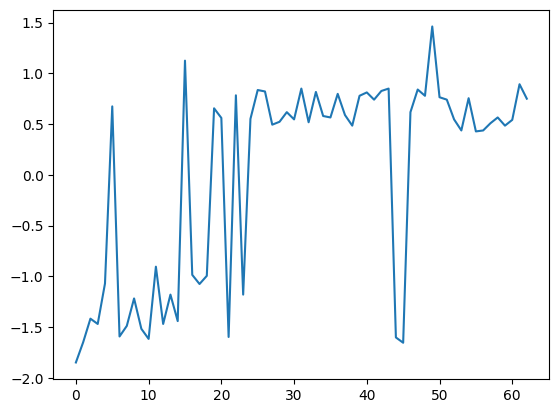

In [67]:
import matplotlib.pyplot as plt
import numpy as np
x = np.array([
        91, 133, 182, 171, 255, 623, 145, 167, 224, 161, 140,290, 171, 232, 177, 718, 273, 254, 271, 
        619, 599, 144, 646, 232, 597, 657, 654, 585, 591, 611, 596, 660, 590, 653, 603, 600, 649, 605, 583,
        645, 652, 637, 655, 660, 143, 132, 611, 658,645, 789, 642, 637, 596, 
        573, 640, 571, 573, 588, 600, 583, 595, 669, 639
        ])
rel_x = (x - np.mean(x)) / np.std(x)
plt.plot(
    rel_x
)

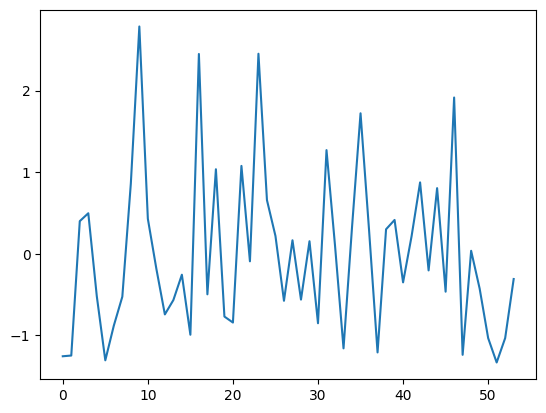

In [68]:
x = np.array([
        137, 140, 702, 735, 388, 120, 265, 386, 859, 1516, 712, 503, 312, 372, 478, 227, 1401, 396, 
        919, 303, 278, 933, 534, 1402, 790,640, 369, 622, 374, 618,275, 999, 600, 170, 677, 1153, 665,
        153, 668, 707, 446, 639, 864, 496, 840, 407, 1219, 143, 578, 420, 213, 111, 213, 460
        ])
rel_x = (x - np.mean(x)) / np.std(x)
plt.plot(
    rel_x
)

In [8]:
env.__getattr__('env_cls')()

In [ ]:
import gym
import random

from environments.env_utils.vec_env.dummy_vec_env import DummyVecEnv
from environments.env_utils.vec_env.subproc_vec_env import SubprocVecEnv
from environments.env_utils.vec_env.vec_normalize import VecNormalize
from environments.wrappers import TimeLimitMask, VariBadWrapper


def make_env(env_id, seed, rank, episodes_per_task, tasks, add_done_info, **kwargs):
    def _thunk():

        env = gym.make(env_id, **kwargs)
        if tasks is not None:
            env.unwrapped.reset_task = lambda x: env.unwrapped.set_task(random.choice(tasks))
        if seed is not None:
            env.seed(seed + rank)
        if str(env.__class__.__name__).find('TimeLimit') >= 0:
            env = TimeLimitMask(env)
        env = VariBadWrapper(env=env, episodes_per_task=episodes_per_task, add_done_info=add_done_info)
        return env

    return _thunk

def make_metaworld_env(env_id, task_id, seed, rank, episodes_per_task,add_done_info, **kwargs):
    def _thunk():
        env = gym.make(env_id, **kwargs)
        env.set_benchmark_task(task_id)
        if seed is not None:
            env.seed(seed + rank)
        if str(env.__class__.__name__).find('TimeLimit') >= 0:
            env = TimeLimitMask(env)
        env = VariBadWrapper(env=env, episodes_per_task=episodes_per_task, add_done_info=add_done_info)
        return env

    return _thunk

def make_vec_envs(env_name, seed, num_processes, gamma,
                  device, episodes_per_task,
                  normalise_rew, ret_rms, tasks,
                  rank_offset=0,
                  add_done_info=None,
                  **kwargs):
    """
    :param ret_rms: running return and std for rewards
    """
    ## hacky work around
    if 'ML10' in env_name:
            envs = [make_metaworld_env(env_id=env_name, 
                    task_id = i,
                    seed=seed, rank=rank_offset + i,
                     episodes_per_task=episodes_per_task,
                     add_done_info=add_done_info,
                     **kwargs)
            for i in range(num_processes)]
    else:
        envs = [make_env(env_id=env_name, seed=seed, rank=rank_offset + i,
                        episodes_per_task=episodes_per_task,
                        tasks=tasks,
                        add_done_info=add_done_info,
                        **kwargs)
                for i in range(num_processes)]

    if len(envs) > 1:
        envs = SubprocVecEnv(envs)
    else:
        envs = DummyVecEnv(envs)

    if len(envs.observation_space.shape) == 1:
        if gamma is None:
            envs = VecNormalize(envs, normalise_rew=normalise_rew, ret_rms=ret_rms)
        else:
            envs = VecNormalize(envs, normalise_rew=normalise_rew, ret_rms=ret_rms, gamma=gamma)

    envs = VecPyTorch(envs, device)

    return envs

In [58]:
102 % len(task_names)

2

In [ ]:

class TestML10Env(gym.Env):

    def __init__(self):
        # initialise blank env
        self.benchmark = metaworld.ML10()
        self.task_names = list(self.benchmark.train_classes.keys())

        # set a random task from the benchmark
        self.set_task()

        # requires self.set_task()
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space

        # metaworld max steps - hardcoded
        self._max_episode_steps = 500

    def set_benchmark_task(self, task_id):
        self.env_name = self.task_names[task_id]
        self.env_cls = self.benchmark.train_classes[self.env_name]
        self.env = self.env_cls()

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        info['task'] = self.task
        return obs, reward, done, info
    
    def reset(self):
        obs, _ = self.env.reset()
        return obs
    
    def get_task(self):
        return self.env_name, self.env_cls
    
    ## reset_task is automatically created in make_env using set_task
    def set_task(self, task = None):
        if task is None:
            task = random.choice(
                [task for task in self.benchmark.train_tasks if task.env_name==self.env_name]
                )

        self.task = task
        self.env.set_task(self.task)

    # duplicated for varibad temporarily
    def reset_task(self, task = None):
        if task is None:
            task = random.choice(
                [task for task in self.benchmark.train_tasks if task.env_name==self.env_name]
                )

        self.task = task
        self.env.set_task(self.task)

In [3]:
ml10 = metaworld.ML10()

In [50]:
import random
task_id = 2
task_names = list(ml10.train_classes.keys())
# env_name, env_cls = 
env_name = task_names[task_id]
env_cls = ml10.train_classes[env_name]
task = random.choice([task for task in ml10.train_tasks if task.env_name==env_name])
print(task_names, env_name, env_cls, task, sep = '\n')


['reach-v2', 'push-v2', 'pick-place-v2', 'door-open-v2', 'drawer-close-v2', 'button-press-topdown-v2', 'peg-insert-side-v2', 'window-open-v2', 'sweep-v2', 'basketball-v2']
pick-place-v2
<class 'metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_pick_place_v2.SawyerPickPlaceEnvV2'>
Task(env_name='pick-place-v2', data=b'\x80\x04\x95=\x01\x00\x00\x00\x00\x00\x00}\x94(\x8c\x08rand_vec\x94\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x06\x85\x94h\x05\x8c\x05dtype\x94\x93\x94\x8c\x02f8\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89C0z9\xbb\x91\x07\xfc\xb5?\x8a\xf1\xbd\xf0b\x19\xe6?\x00\x00\x00@\xe1z\x94?;ll\x0cPn\xa4\xbf\xda,*\xb0\x9e\x7f\xea?N\x1f[\xc9\xdd\xfa\xd1?\x94t\x94b\x8c\x07env_cls\x94\x8c8metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_pick_place_v2\x94\x8c\x14SawyerPickPlaceEnvV2\x94\x93\x94\x8c\x14partially_observable\x94\x88u.')


In [20]:
'ML10' in 'CustomML10-v2'

True

In [4]:
ml10_env = gym.make('ML10-v2')

In [12]:
# env = gym.make('ML10-v2')
varibad_env = make_env('ML10-v2', 1, 1, 2, tasks = None, add_done_info =True)

In [13]:
vbad_ml10 = varibad_env()

In [14]:
vbad_ml10.done_mdp

True

In [15]:
vbad_ml10.reset_mdp()


array([ 0.00615235,  0.6001898 ,  0.19430117,  1.        , -0.03745555,
        0.68238707,  0.01987216,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00615235,  0.6001898 ,
        0.19430117,  1.        , -0.03745555,  0.68238707,  0.01987216,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [16]:
vbad_ml10.observation_space


Box(40,)

In [17]:
vbad_ml10.episodes_per_task

2